In [1]:
%reload_ext autoreload
%autoreload 2

import os
PATH = os.getenv("HOME")
os.chdir(f"{PATH}/watttime-python-client-aer-algo")

from watttime.api import WattTimeHistorical

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from src.utils import *

In [21]:
wt_hist = WattTimeHistorical(username,password)
df1 = wt_hist.get_historical_pandas(start = '2023-01-01 00:00Z', end='2024-12-31 00:00Z', region = "SPP_SIOUX")
df1["region"] = "SPP_SIOUX"

In [ ]:
df2 = wt_hist.get_historical_pandas(start = '2023-01-01 00:00Z', end='2024-12-31 00:00Z', region = "SC")
df2["region"] = "SC"

In [18]:
df3 = wt_hist.get_historical_pandas(start = '2023-01-01 00:00Z', end='2024-12-31 00:00Z', region = "PJM_ROANOKE")
df3["region"] = "PJM_ROANOKE"

In [19]:
df4 = wt_hist.get_historical_pandas(start = '2023-01-01 00:00Z', end='2024-12-31 00:00Z', region = "PJM_NJ")
df4["region"] = "PJM_NJ"

In [20]:
df5 = wt_hist.get_historical_pandas(start = '2023-01-01 00:00Z', end='2024-12-31 00:00Z', region = "PJM_CHICAGO")
df5["region"] = "PJM_CHICAGO"

## TZ Conversion

In [ ]:
#df = pd.concat([df1, df2,df3,df4,df5])
df = pd.read_csv('/Users/jen/Desktop/region_actuals.csv')
df["point_time"] = pd.to_datetime(df["point_time"])

In [ ]:
# convert to local time
#target_timezone = get_timezone_from_dict("SPP_SIOUX")
#df["point_time_local"] = df["point_time"].dt.tz_convert(target_timezone)

# nyse trading hours
df["time_est"] = df["point_time"].dt.tz_convert('America/New_York')
df["date_est"]  = df.time_est.dt.date
df["hour_est"]  = df.time_est.dt.hour
df["month_est"] = df.time_est.dt.month
df["weekday"] = df.time_est.dt.weekday
df["year"] = df.time_est.dt.year
df["year-month"] = df["year"].astype(str) + '-' + df["month_est"].astype(str)

In [ ]:
df = df.query('year > 2022')
df.rename({"value":"marginal_emissions"}, axis=1, inplace=True)

In [21]:
df["marginal_emissions_kwh"] = df["marginal_emissions"] / 1000

## Load Shifting Potential

In [22]:
# CO2 per 1 kWh of energy = 1.15
df.groupby(["year","region"]).marginal_emissions_kwh.mean()

year  region     
2023  PJM_CHICAGO    1.160705
      PJM_NJ         1.176113
      PJM_ROANOKE    1.214217
      SC             1.603157
      SPP_SIOUX      1.154586
2024  PJM_CHICAGO    1.136959
      PJM_NJ         1.204984
      PJM_ROANOKE    1.222415
      SC             1.606315
      SPP_SIOUX      1.060744
Name: marginal_emissions_kwh, dtype: float64

In [24]:
# CO2 per 1 kWh of energy = 1.15
df.groupby(["year","hour_est","region"],as_index=False).marginal_emissions_kwh.mean().reset_index().to_csv("hour_intensities.csv")

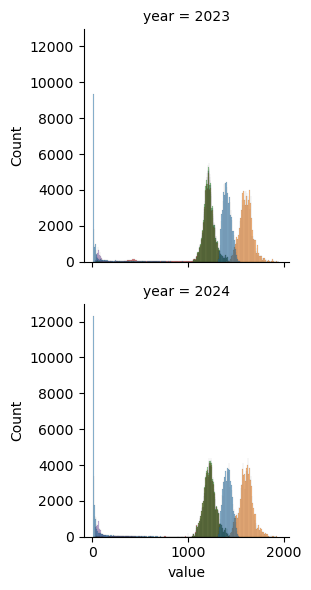

In [37]:
g = sns.FacetGrid(df, row="year",sharex=True)
g.map_dataframe(sns.histplot, x = "value", hue = "region")
g.add_legend()

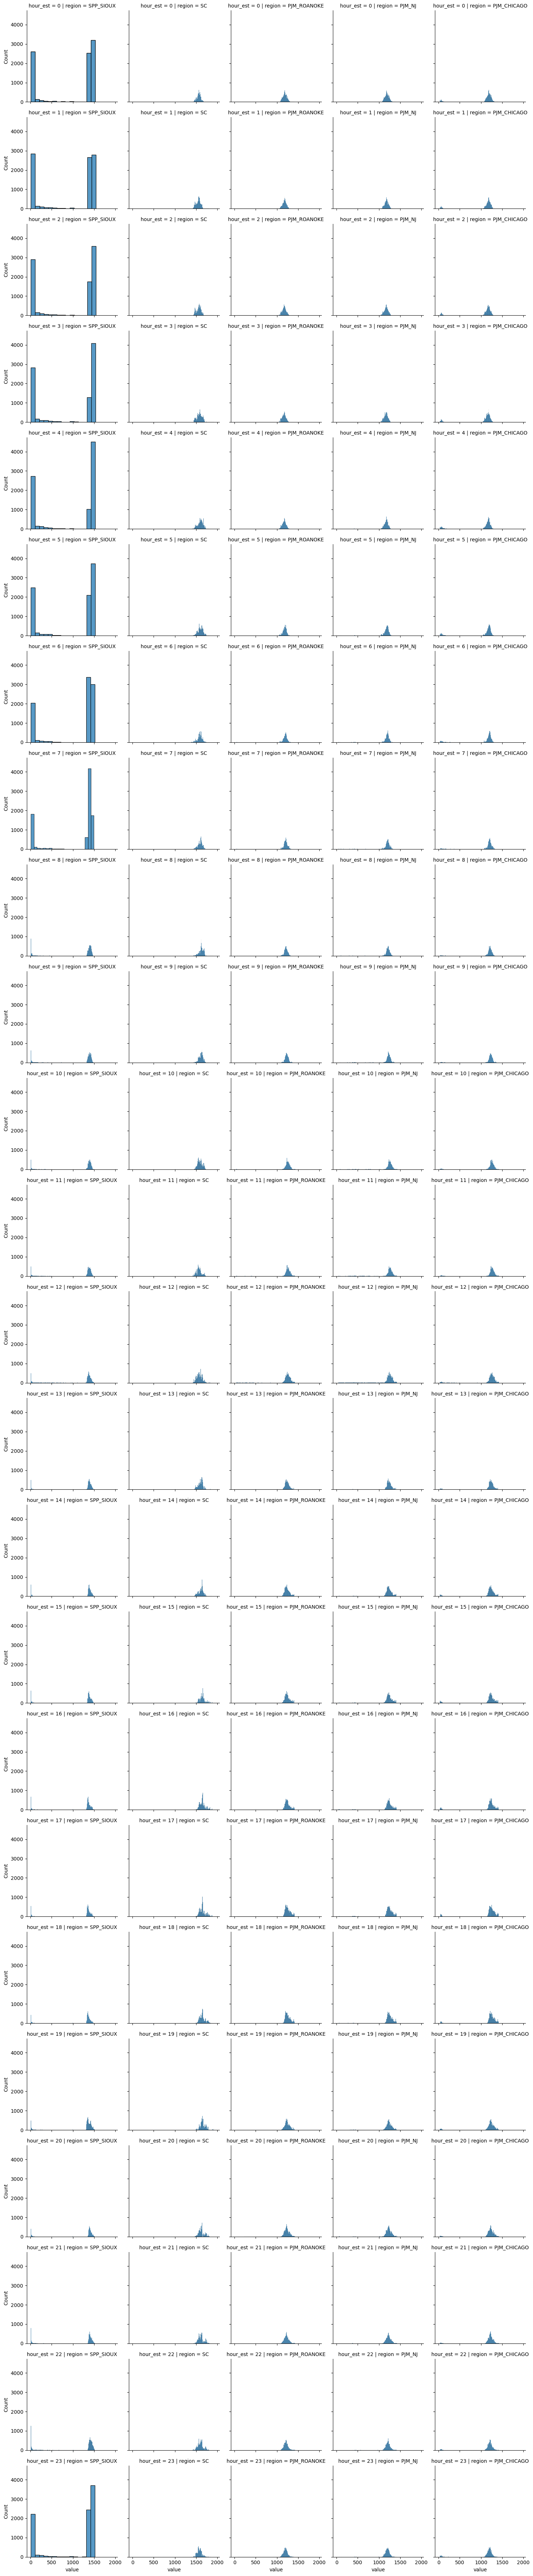

In [ ]:
g = sns.FacetGrid(df, col="region",row="hour_est", sharex=True)
g.map(sns.histplot,"marginal_emissions_kwh")

<Figure size 2500x800 with 0 Axes>

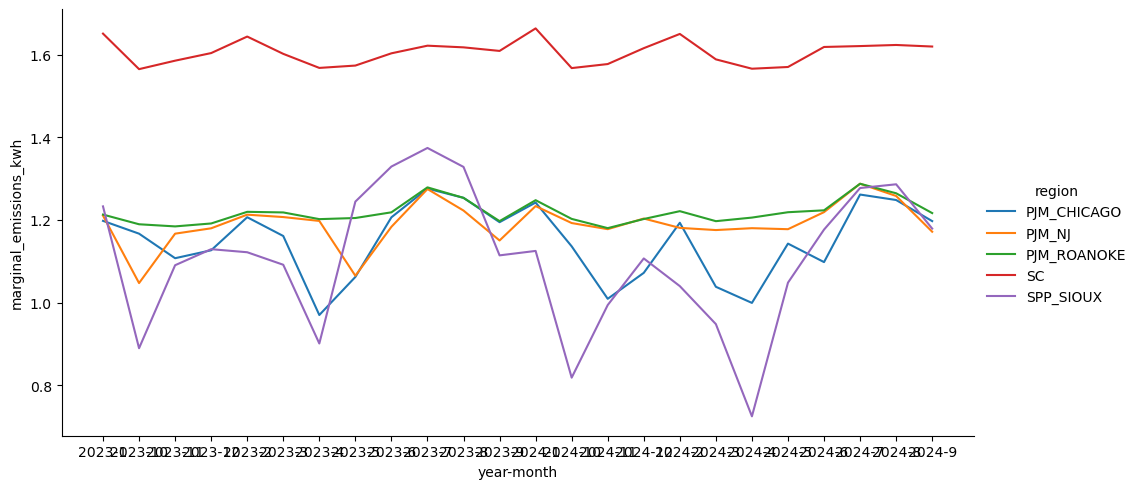

In [25]:
f = plt.figure(figsize=(25,8))
sns.relplot(
    data=df.groupby(["year-month","region"], as_index=False)["marginal_emissions_kwh"].mean(),
    kind="line",
    x="year-month", 
    y="marginal_emissions_kwh",
    hue="region",
    aspect = 2,
    legend='full'
)

/var/folders/kf/cqbq1hkx74v5lt73jq2w60x40000gn/T/ipykernel_26024/2195012857.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


<Figure size 2000x800 with 0 Axes>

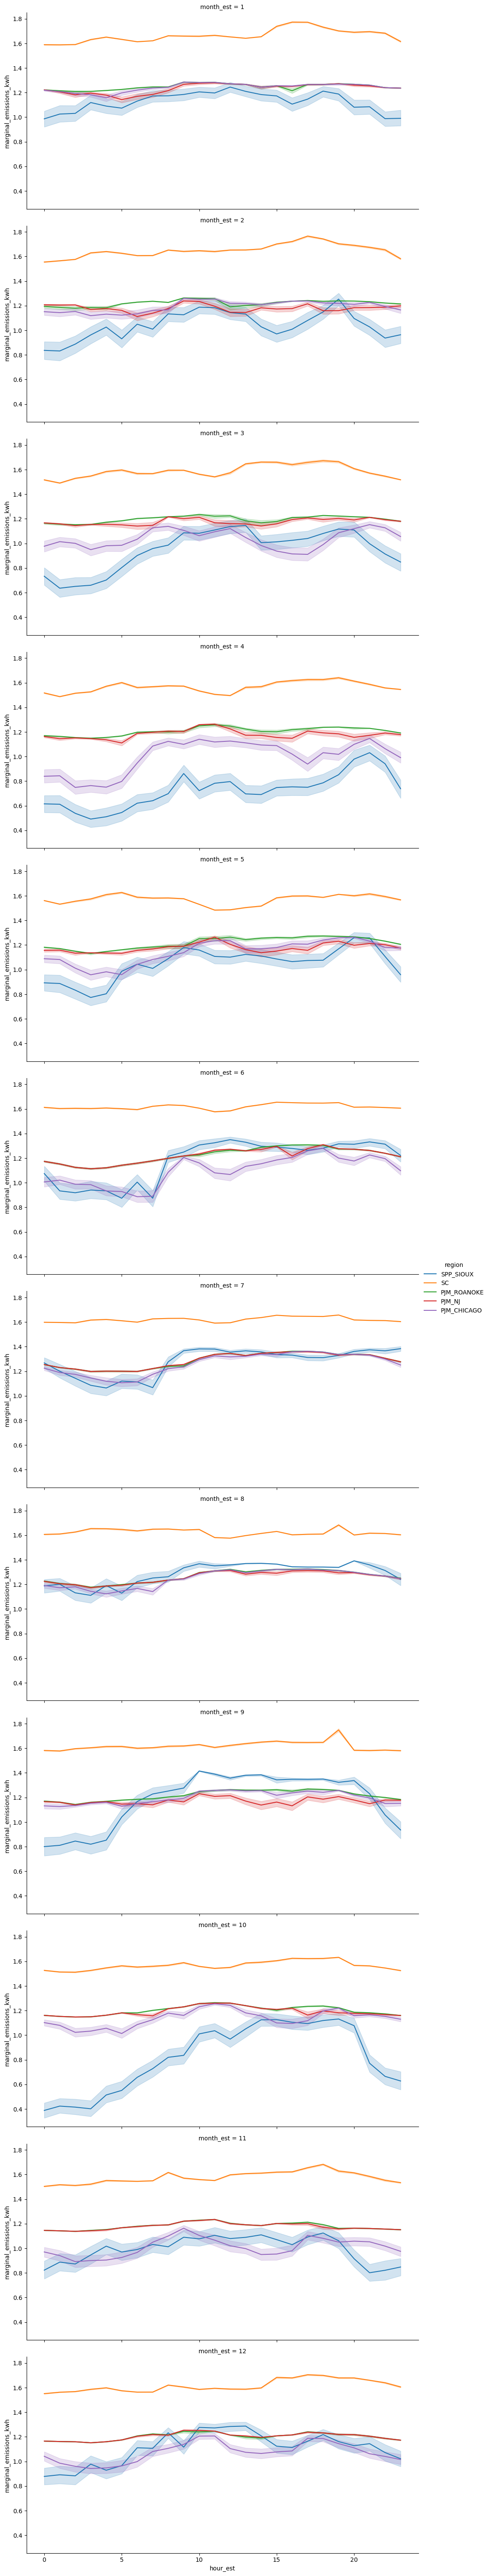

In [34]:
f = plt.figure(figsize=(20,8))
sns.relplot(
    data=df[df["year"] > 2023],
    kind="line",
    x="hour_est", 
    y="marginal_emissions_kwh",
    hue="region",
    row="month_est",
    aspect = 2,
    legend='full'
)

f.show()

In [44]:
df.pivot(index='point_time',columns='region',values='value').corr(method="spearman")

region       PJM_CHICAGO    PJM_NJ  PJM_ROANOKE        SC  SPP_SIOUX
region                                                              
PJM_CHICAGO     1.000000  0.834739     0.919717  0.251010  -0.078250
PJM_NJ          0.834739  1.000000     0.895374  0.244860  -0.082789
PJM_ROANOKE     0.919717  0.895374     1.000000  0.247932  -0.107644
SC              0.251010  0.244860     0.247932  1.000000   0.013950
SPP_SIOUX      -0.078250 -0.082789    -0.107644  0.013950   1.000000

In [ ]:
f = plt.figure(figsize=(20,8))
sns.relplot(
    data=df.query('year < 2024'),
    kind="line",
    x="hour_est", 
    y="value",
    hue="month_est",
    row="region",
    aspect = 2,
    palette = plt.get_cmap('coolwarm',12),
    legend='full'
)

f.show()

/var/folders/kf/cqbq1hkx74v5lt73jq2w60x40000gn/T/ipykernel_26024/1120429648.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


<Figure size 2000x800 with 0 Axes>

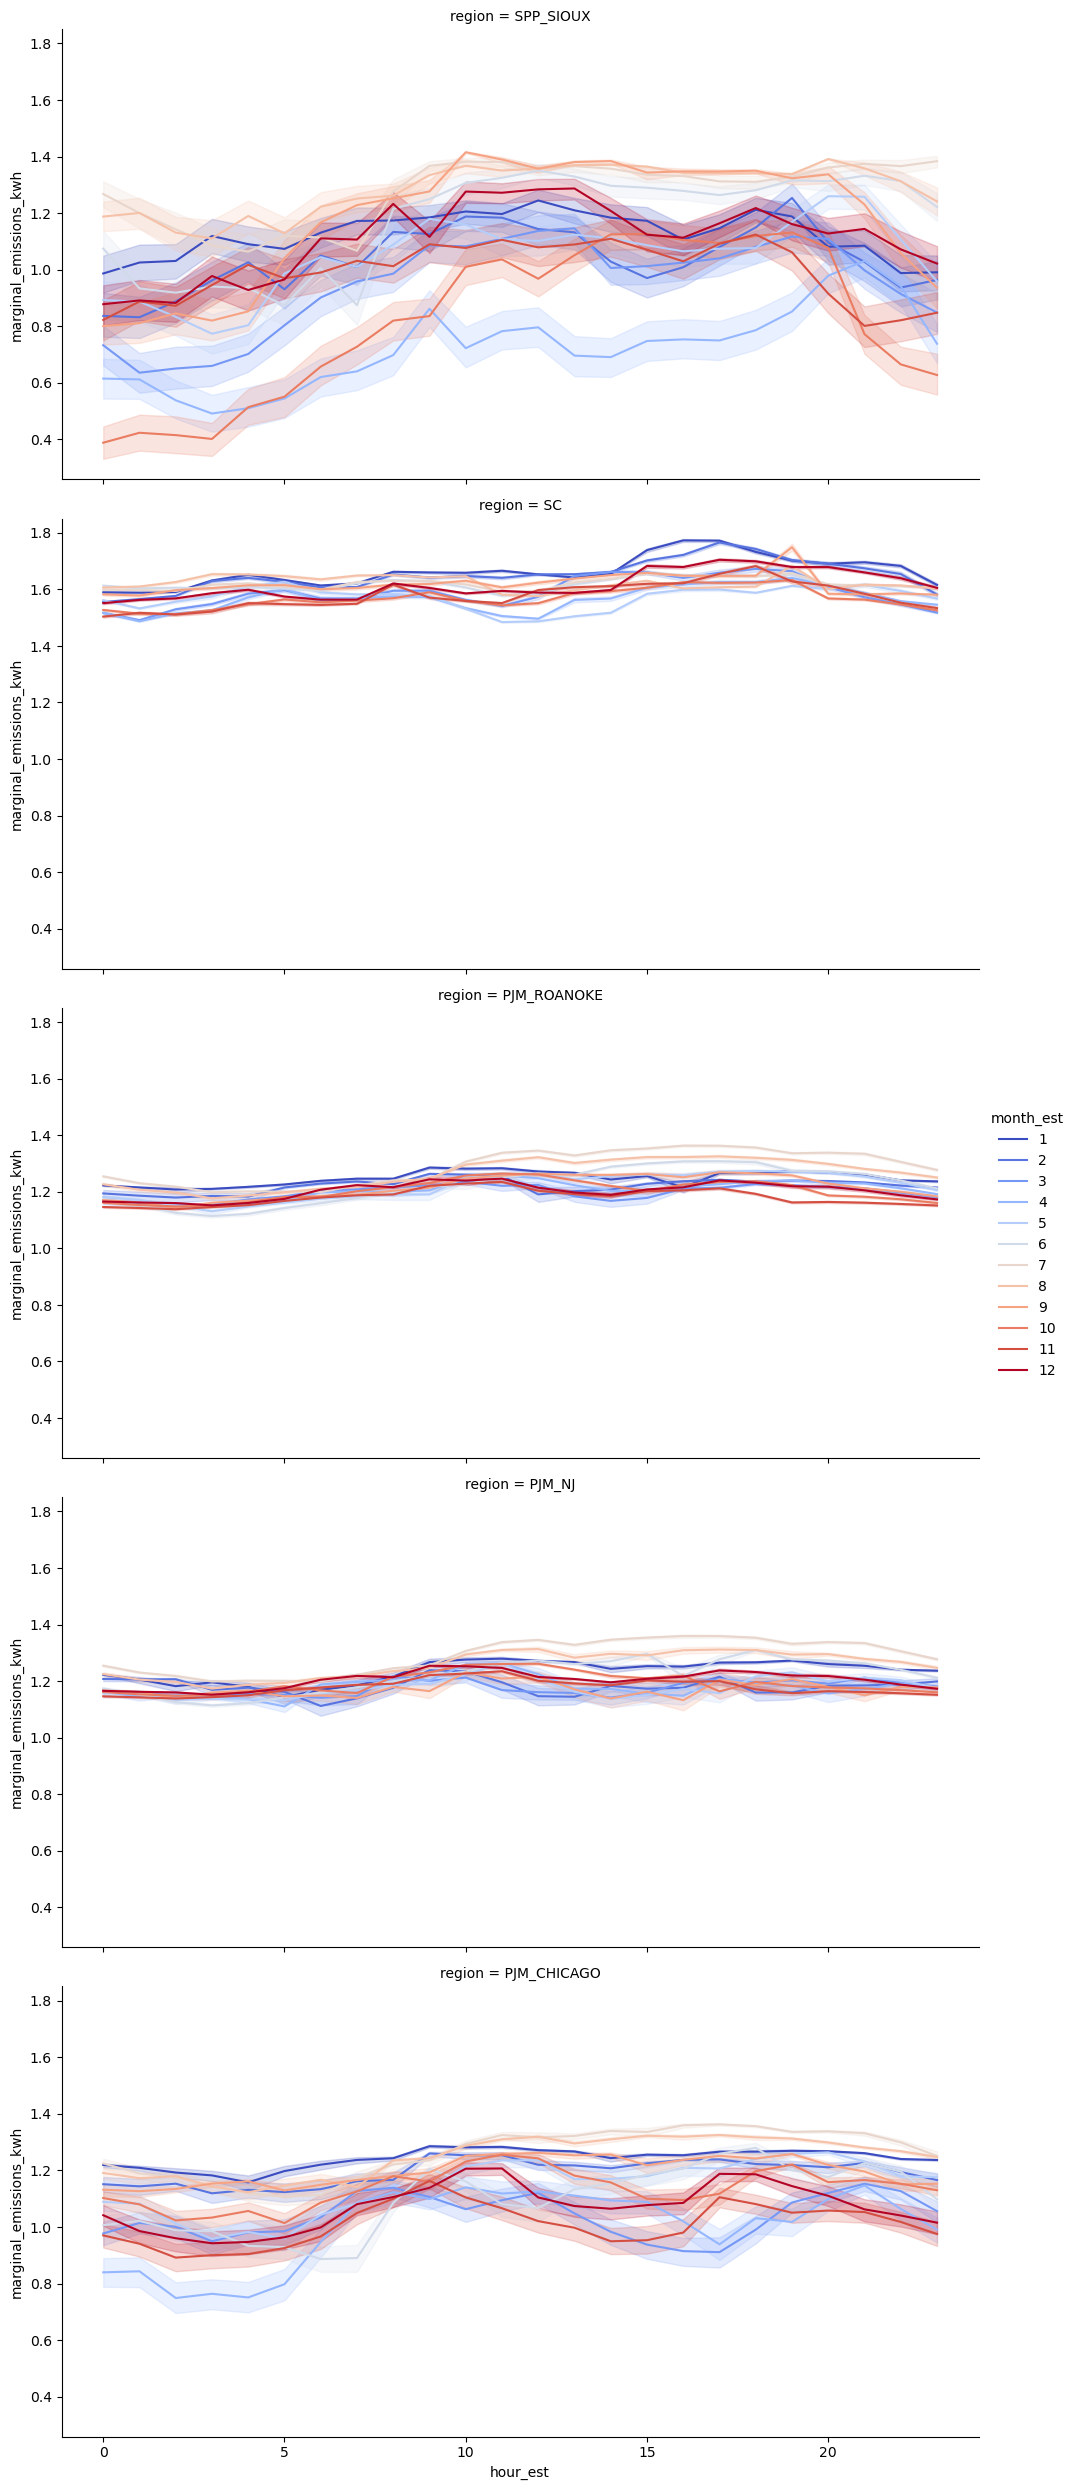

In [36]:
f = plt.figure(figsize=(20,8))
sns.relplot(
    data=df.query('year > 2023'),
    kind="line",
    x="hour_est", 
    y="marginal_emissions_kwh",
    hue="month_est",
    row="region",
    aspect = 2,
    palette = plt.get_cmap('coolwarm',12),
    legend='full'
)

f.show()

In [38]:
hour_avg = df.groupby(["year","region","month_est","date_est","hour_est"])["marginal_emissions_kwh"].describe().reset_index()

In [39]:
hour_avg.to_csv("hour_month_year_intensities.csv")

In [40]:
hour_avg_rank = hour_avg.groupby(["year","region","date_est"])["mean"].nsmallest(6).reset_index().set_index("level_3").merge(hour_avg[["hour_est","std","min","25%","50%","75%","max"]], left_index=True,right_index=True)

In [41]:
hour_avg_rank

year       region    date_est      mean  hour_est           std    min  \
23     2023  PJM_CHICAGO  2023-01-01  1.157000        23  1.153650e-02  1.139   
22     2023  PJM_CHICAGO  2023-01-01  1.167250        22  1.901256e-02  1.149   
1      2023  PJM_CHICAGO  2023-01-01  1.172750         1  3.333712e-03  1.169   
0      2023  PJM_CHICAGO  2023-01-01  1.174583         0  2.745520e-03  1.166   
4      2023  PJM_CHICAGO  2023-01-01  1.179583         4  2.234373e-03  1.175   
...     ...          ...         ...       ...       ...           ...    ...   
87552  2024    SPP_SIOUX  2024-12-30  0.013000         2  3.623719e-18  0.013   
87555  2024    SPP_SIOUX  2024-12-30  0.013417         5  5.149287e-04  0.013   
87567  2024    SPP_SIOUX  2024-12-30  0.013667        17  7.784989e-04  0.013   
87566  2024    SPP_SIOUX  2024-12-30  0.014083        16  2.234373e-03  0.011   
87556  2024    SPP_SIOUX  2024-12-30  0.014250         6  5.029459e-03  0.011   

           25%     50%      75%    max  
23     1.14775  1.1595  1.16800  1.171  
22     1.15750  1.1590  1.16600  1.209  
1      1.17050  1.1715  1.17525  1.179  
0      1.17500  1.1750  1.17600  1.176  
4      1.18000  1.1800  1.18100  1.182  
...        ...     ...      ...    ...  
87552  0.01300  0.0130  0.01300  0.013  
87555  0.01300  0.0130  0.01400  0.014  
87567  0.01300  0.0135  0.01400  0.015  
87566  0.01275  0.0140  0.01450  0.018  
87556  0.01275  0.0130  0.01325  0.030  

[21900 rows x 11 columns]

<Axes: xlabel='hour_est', ylabel='percent'>

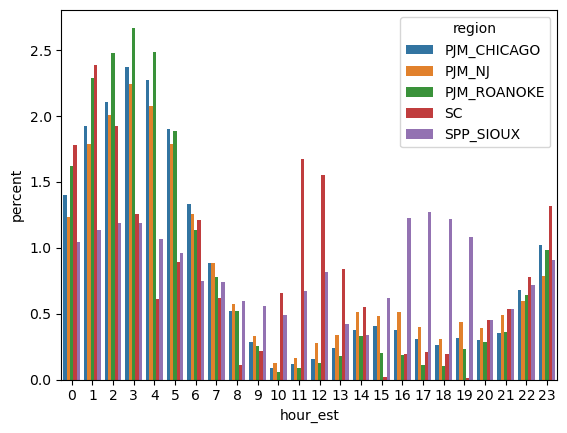

In [53]:
sns.countplot(data = hour_avg_rank, x = "hour_est", hue="region", stat="percent")
#hour_avg_rank.hour_est.value_counts(normalize = True).plot(kind = "bar")

<Axes: xlabel='hour_est', ylabel='mean'>

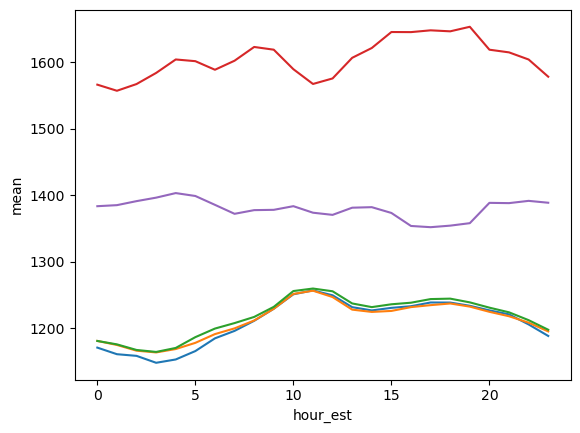

In [ ]:
sns.lineplot(hour_avg.groupby(["region","hour_est"])["mean"].median().reset_index(), x = "hour_est", y = "mean", hue="region", legend=True)

<Axes: xlabel='hour_est', ylabel='mean'>

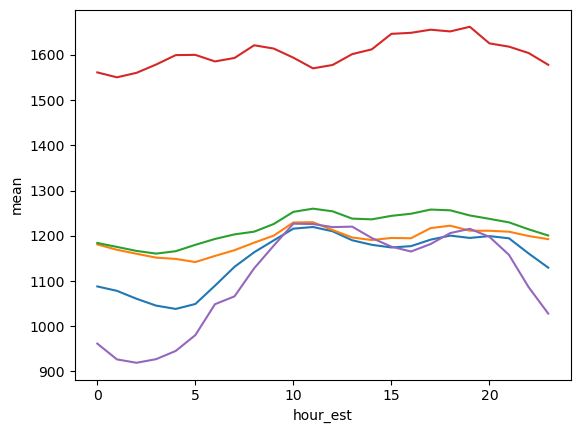

In [ ]:
sns.lineplot(hour_avg.groupby(["region","hour_est"])["mean"].mean().reset_index(), x = "hour_est", y = "mean", hue="region", legend=True)

<Axes: xlabel='hour_est', ylabel='mean'>

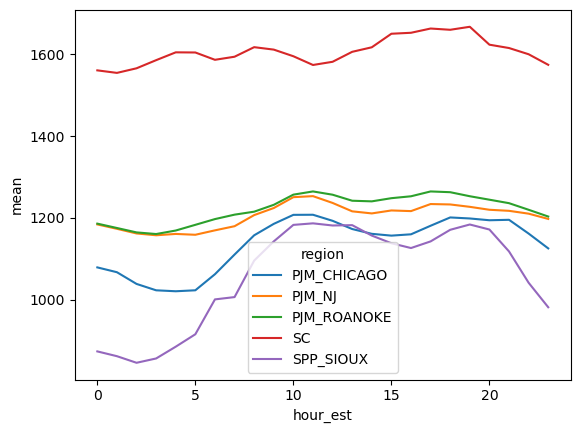

In [56]:
sns.lineplot(hour_avg.query('year > 2023').groupby(["region","hour_est"])["mean"].mean().reset_index(), x = "hour_est", y = "mean", hue="region")

<Axes: xlabel='hour_est', ylabel='mean'>

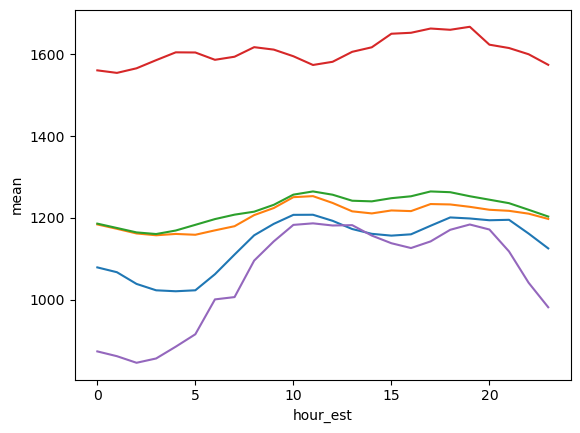

In [58]:
sns.lineplot(hour_avg.query('year > 2023').groupby(["region","hour_est"])["mean"].mean().reset_index(), x = "hour_est", y = "mean", hue="region", legend=False)

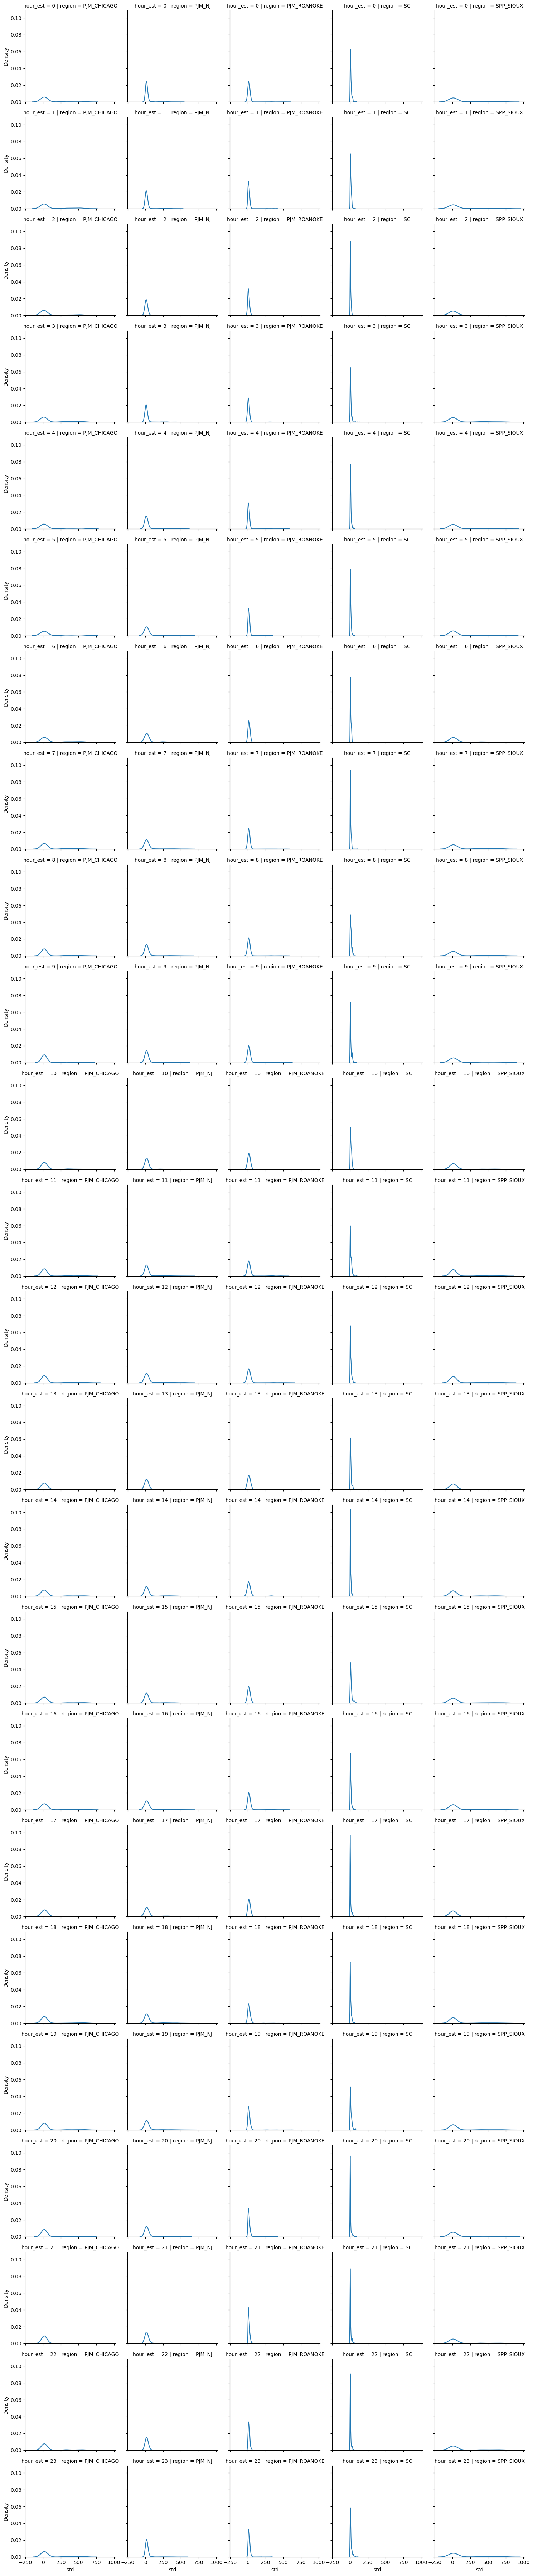

In [57]:
g = sns.FacetGrid(hour_avg, col="region",sharex=True, row="hour_est")
g.map(sns.kdeplot,"std")

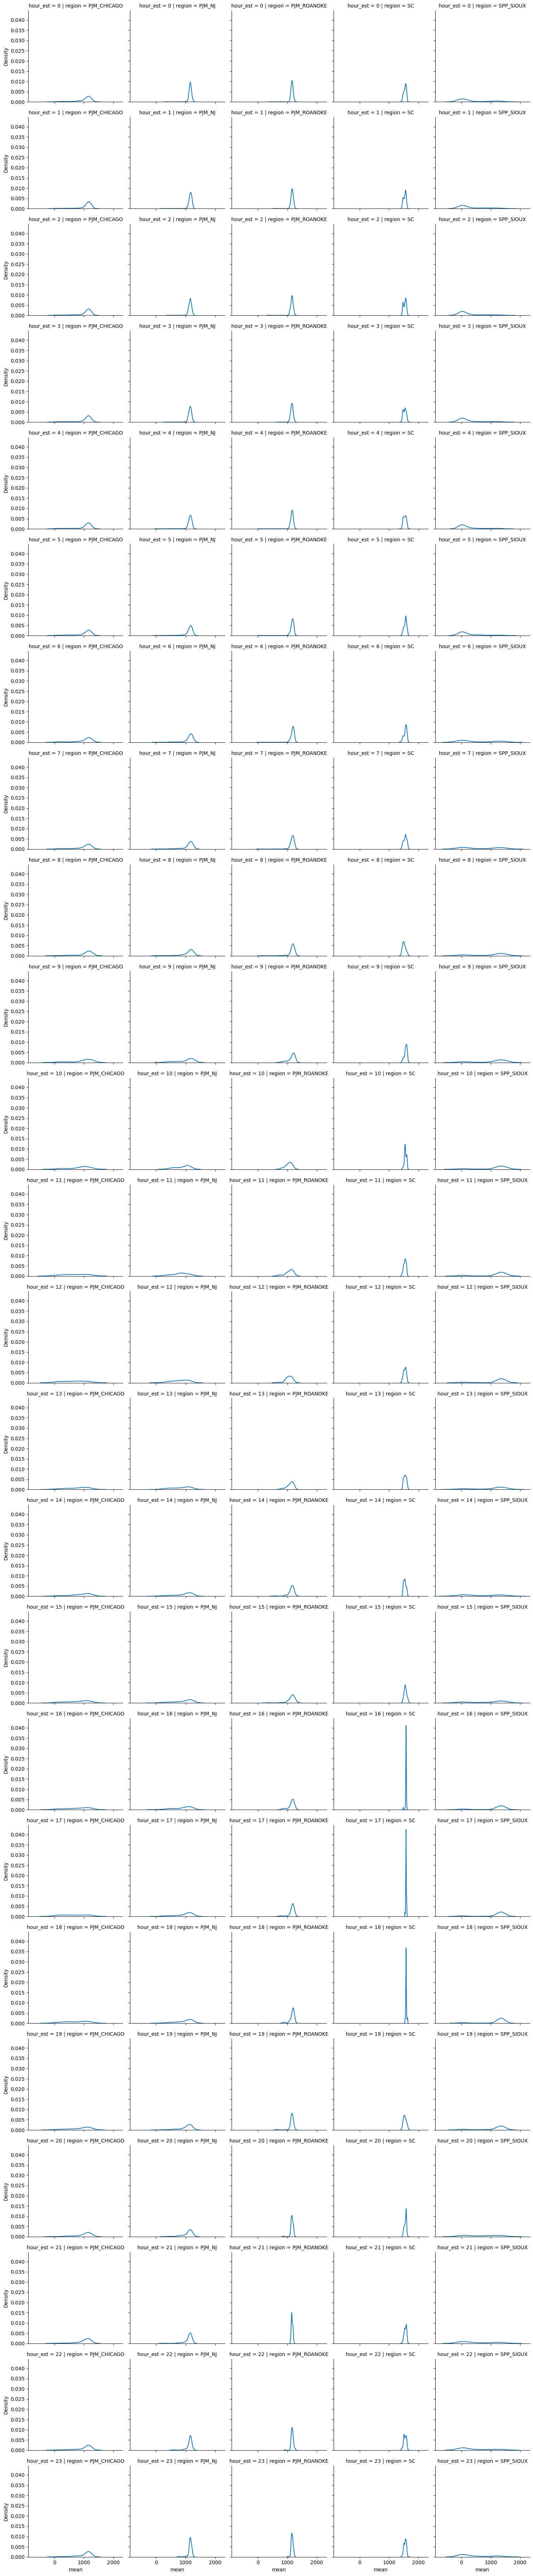

In [60]:
g = sns.FacetGrid(hour_avg_rank, col="region",sharex=True, row="hour_est")
g.map(sns.kdeplot,"mean")

## By Trading Hour

In [24]:
df["trading_hour"] = [True if x in [8,9,10,11,12,13,14,15,16,17] else False for x in df["hour_cst"]]